In [19]:
import os
import math
import random
import subprocess

import numpy   as np
import pandas  as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd

from tqdm import tqdm

from mpl_toolkits.basemap import Basemap

pd.set_option('mode.chained_assignment', None)

In [2]:
%%time

filename = "data/data.csv"

def file_len(fname):
    p = subprocess.Popen(['wc', '-l', fname], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    result, err = p.communicate()
    if p.returncode != 0:
        raise IOError(err)
    return int(result.strip().split()[0]) + 1

n_rows = file_len(filename)
print('Data file contains {} rows'.format(n_rows))

Data file contains 9495237 rows
CPU times: user 1.92 ms, sys: 7.43 ms, total: 9.35 ms
Wall time: 2.47 s


In [3]:
traintypes = {
    'trip_id': 'int32',
    'year': 'uint16',
    'month': 'uint8',
    'week': 'uint8',
    'day': 'uint8',
    'hour': 'uint8',
    'usertype': 'str',
    'gender': 'str',
    'starttime': 'str',
    'stoptime': 'str',
    'tripduration': 'float32',
    'temperature': 'float32',
    'events': 'str',
    'from_station_id': 'int32',
    'from_station_name': 'str',
    'latitude_start': 'float32',
    'longitude_start': 'float32',
    'dpcapacity_start': 'float32',
    'to_station_id': 'int32',
    'to_station_name': 'str',
    'latitude_end': 'float32',
    'longitude_end': 'float32',
    'dpcapacity_end': 'float32'
}
cols = list(traintypes.keys())

In [5]:
chunksize = 1_000_000

In [6]:
%%time
df_list = []

for df_chunk in tqdm(
    pd.read_csv(
        filename, 
        usecols=cols, 
        dtype=traintypes, 
        chunksize=chunksize
    )
):
    df_chunk['starttime'] = df_chunk['starttime'].str.slice(0, 16)
    df_chunk['starttime'] = pd.to_datetime(df_chunk['starttime'], utc=True, format='%Y-%m-%d %H:%M')
    
    df_list.append(df_chunk)

10it [00:32,  3.30s/it]

CPU times: user 30.6 s, sys: 2.33 s, total: 32.9 s
Wall time: 33 s


In [12]:
data_df = pd.concat(df_list[0:5])

del df_list

data_df.info()
n_rows = data_df.shape[0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 23 columns):
trip_id              int32
year                 uint16
month                uint8
week                 uint8
day                  uint8
hour                 uint8
usertype             object
gender               object
starttime            datetime64[ns, UTC]
stoptime             object
tripduration         float32
temperature          float32
events               object
from_station_id      int32
from_station_name    object
latitude_start       float32
longitude_start      float32
dpcapacity_start     float32
to_station_id        int32
to_station_name      object
latitude_end         float32
longitude_end        float32
dpcapacity_end       float32
dtypes: datetime64[ns, UTC](1), float32(8), int32(3), object(6), uint16(1), uint8(4)
memory usage: 505.4+ MB
5000000


In [45]:
def haversine(row):
    
    lon1 = row['longitude_start']
    lat1 = row['latitude_start']
    lon2 = row['longitude_end']
    lat2 = row['latitude_end']

    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1 
    dlat = lat2 - lat1 

    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 

    km = 6367 * c

    return km

In [73]:
lines = False
def show_ride(row_no, full_city=False):
    
    from_x = data_df['longitude_start'][row_no]
    from_y = data_df['latitude_start'][row_no]
    
    to_x = data_df['longitude_end'][row_no]
    to_y = data_df['latitude_end'][row_no]
    
    data_x = [from_x, to_x]
    data_y = [from_y, to_y]
       
    if full_city:
        ll_lon = -87.80
        ll_lat = 41.82

        ur_lon = -87.55
        ur_lat = 42.00
    else:
        ll_lon = min(from_x, to_x) - 0.04
        ll_lat = min(from_y, to_y) - 0.04

        ur_lon = max(from_x, to_x) + 0.04
        ur_lat = max(from_y, to_y) + 0.04

    plt.figure(figsize=(30,30))

    chicago_map = Basemap(
        llcrnrlon=ll_lon, 
        llcrnrlat=ll_lat, 
        urcrnrlon=ur_lon, 
        urcrnrlat=ur_lat,        
        
        epsg=3435
    )
    chicago_map.arcgisimage(
        service='World_Street_Map', 
        xpixels = 5000, 
        verbose= True
    )

    if (lines):
        parallels = np.arange(0.,90,0.1)
        meridians = np.arange(10.,351.,0.1)
        chicago_map.drawparallels(
            parallels,
            labels=[False,True,True,False], 
            color='white', 
            textcolor='white'
        )
        chicago_map.drawmeridians(
            meridians,
            labels=[True,False,False,True], 
            color='white', 
            textcolor='white'
        )
    
    chicago_map.scatter(
        
        x=data_x,
        y=data_y,
        
        alpha=1,
        c='r',
        
        s=500,
        marker='.',
        
        latlon=True
    )
    chicago_map.drawgreatcircle(
        from_x,
        from_y,
        to_x,
        to_y,
        linewidth=2,
        color='b'
    )
    
    print('\n\nDistance covered: %.2f km' % 
          (haversine(data_df.iloc[row_no, :])))
    
    print('Ride duration: %d minutes' % 
          (data_df['tripduration'][row_no]))
    
    print('Ride average speed: %.2f km/hr' % 
          (haversine(data_df.iloc[row_no, :]) / float(data_df['tripduration'][row_no])))
    
    datetime_list = str(data_df['starttime'][row_no]).split(' ')
    print('Ride date: %s \t Ride time: %s' % 
          (datetime_list[0], datetime_list[1]))
    
    print('Temperature: %d°F' % (int(data_df['temperature'][row_no])))
    
    print('Rider gender: %s' % data_df['gender'][row_no])


http://server.arcgisonline.com/ArcGIS/rest/services/World_Street_Map/MapServer/export?bbox=1164476.196682745,1886647.2555882002,1187609.6005671353,1916829.3428621201&bboxSR=3435&imageSR=3435&size=5000,6523&dpi=96&format=png32&transparent=true&f=image


Distance covered: 0.55 km
Ride duration: 20 minutes
Ride average speed: 0.03 km/hr
Ride date: 2014-09-08 	 Ride time: 12:49:00+00:00
Temperature: 75°F
Rider gender: Male


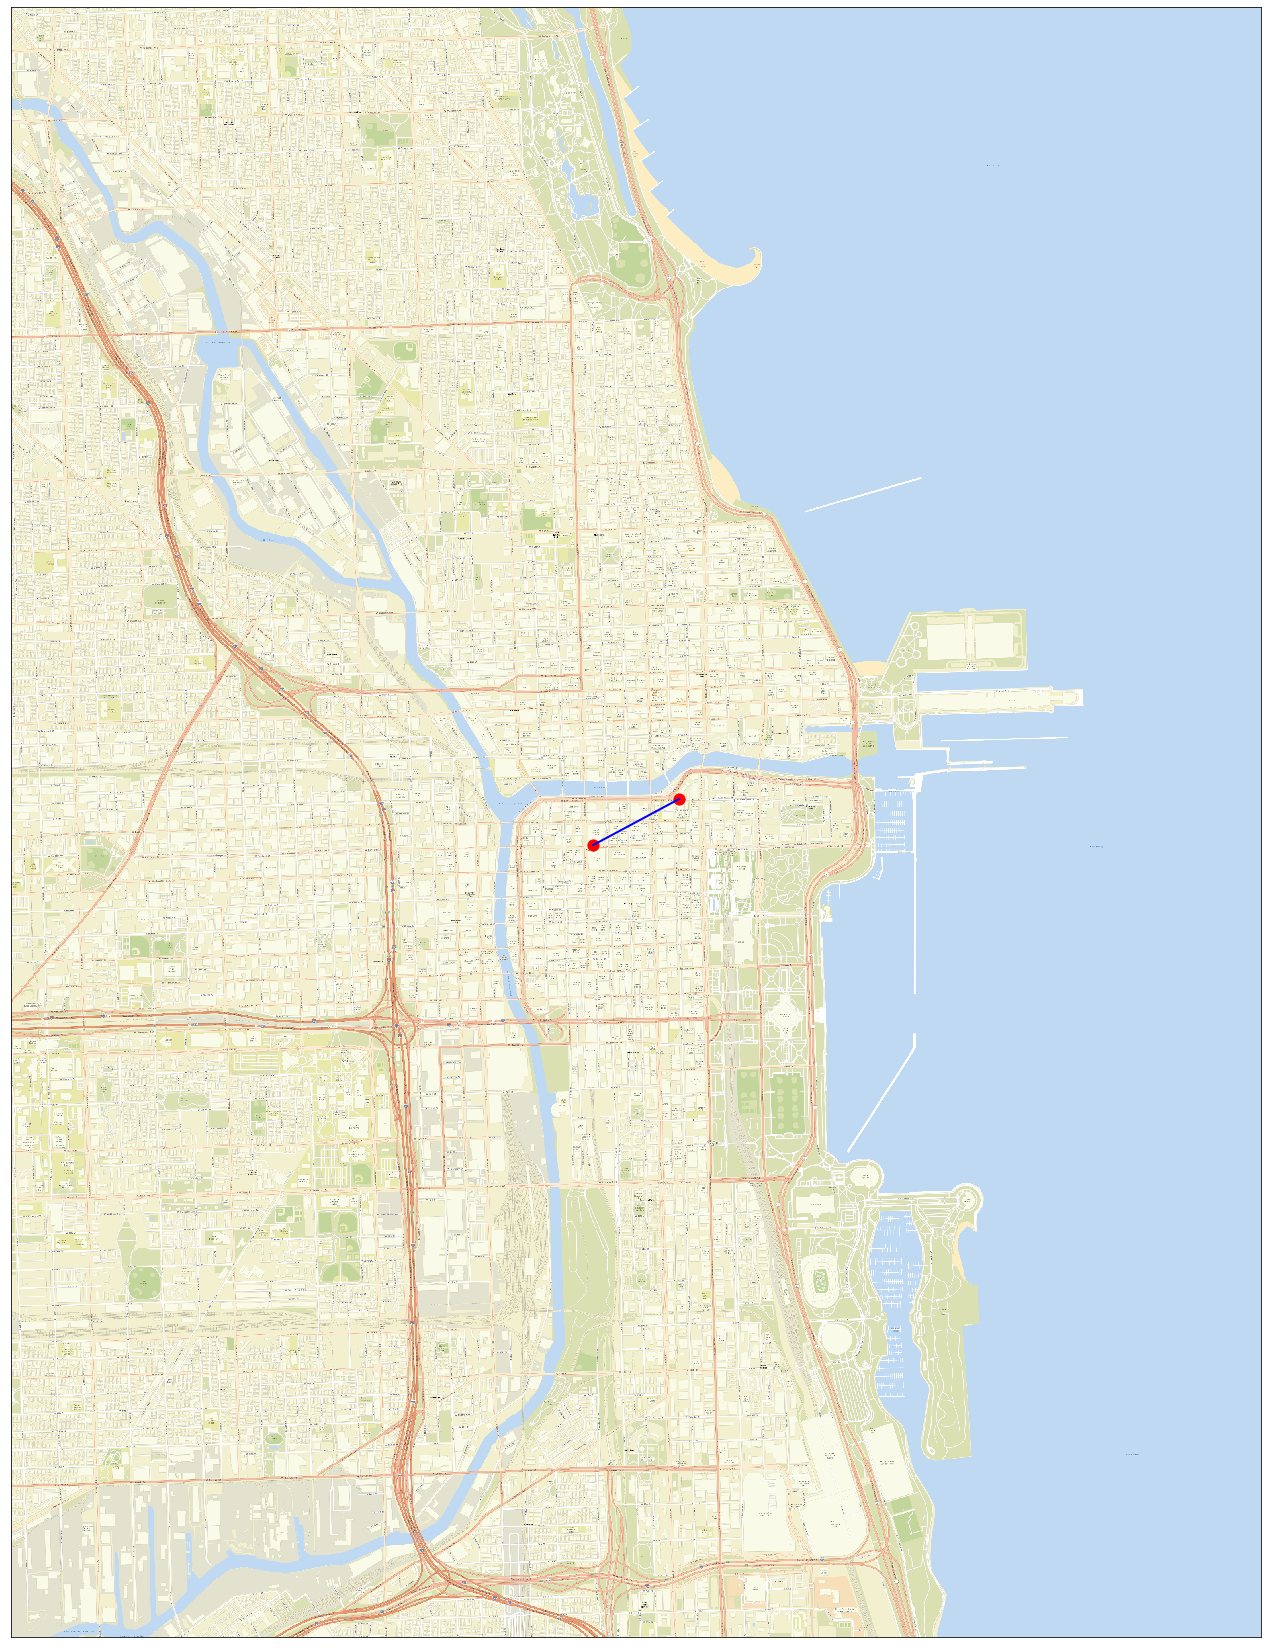

In [74]:
random_ix = np.random.randint(0, n_rows)
show_ride(row_no=random_ix, full_city=False)